## In-Session Analysis

Predict next best song *within* each session, using the previous 15 songs in the session.

In [38]:
from pathlib import Path
import pandas as pd
import numpy as np
import os
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import warnings
from itertools import tee

# Model Building
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Suppress scientific notation
pd.options.display.float_format = '{:20,.2f}'.format

warnings.filterwarnings("ignore")

In [2]:
#os.chdir("..")

## Data Pre-processing

- Join session level data with track context/features
- Convert rewards to binary -1 = skipped, 1 = not skipped
- Encode categorical track and dsession features
- Create features dataframe which contains cleaned/OHE vector of track features

In [3]:
# Load in Data
df_sessions_sampled = pd.read_csv('data/training_set/log_sampled.csv')
df_tracks_sampled = pd.read_csv('data/track_features/tf_sampled.csv')
print("Number of sessions in DF: " + str(len(df_sessions_sampled['session_id'].unique())))
print("Number of tracks in DF: " + str(len(df_tracks_sampled['track_id'].unique())))
# Sanity check num tracks in tracks df equals num tracks in sessions df
assert len(df_sessions_sampled['track_id_clean'].unique()) == len(df_tracks_sampled['track_id'].unique())

Number of sessions in DF: 178342
Number of tracks in DF: 319008


In [4]:
## Join dataframes together on 'track_id'
spotify = df_sessions_sampled.merge(df_tracks_sampled, left_on="track_id_clean", right_on="track_id")
#print(spotify.isna().sum())
spotify.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,4,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21
1,0_00079a23-1600-486a-91bd-5208be0c745a,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,True,False,0,0,...,4,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,4,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9,13,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,1,...,4,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,True,False,0,0,...,4,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21


In [5]:
## BINARY REWARDS (skip/no skip)
# spotify['response'] = np.where(
#     spotify['not_skipped']==True,
#     1,
#     -1
# )
# spotify = spotify.drop(columns=['skip_1', 'skip_2', 'skip_3', 'not_skipped'])
# spotify.head()

In [6]:
## MULTICLASS REWARDS
# response = -1, track was skipped
# response = 0, track was only played briefly and skipped
# response = 1, most of the track was played and skipped
# response = 2, track was played in its entirety and not skipped

spotify['response'] = np.where(
    spotify['not_skipped']==True,
    2,
    np.where(spotify['skip_1']==True, -1, 
             np.where(spotify['skip_2']==True, 0, 1))
)
spotify = spotify.drop(columns=['skip_1', 'skip_2', 'skip_3', 'not_skipped'])
spotify.head()

,session_id,session_position,session_length,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,...,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,response
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,0,0,0,0,...,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21,2
1,0_00079a23-1600-486a-91bd-5208be0c745a,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21,1
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21,2
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9,13,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,1,0,0,0,0,...,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21,2
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21,1


## Encode relevant user context data - behavior
To booleans:
- shuffle (0/1)
- premium (0/1)

To float:
- all int columns
- date --> year, month

To OHE vectors:
- context (catalog, charts, editorial playlist, personalized playlist, radio, user collection)
- track end reason (appload, backbtn, clickrow, endplay, fwdbtn, logout, remote, trackdone)

In [7]:
# Convert binary columns to booleans
data_bool_cols = spotify.columns[spotify.dtypes=='bool']
for col in data_bool_cols:
    spotify[col]=spotify[col].astype(int)
spotify['mode'] = spotify['mode'].astype(bool).astype(int)

In [8]:
from datetime import datetime

spotify['date'] = pd.to_datetime(spotify.date, format='%Y-%m-%d')
spotify['year']=spotify['date'].dt.year
spotify['month']=spotify['date'].dt.month
spotify = spotify.drop(columns='date')
spotify.head()

,session_id,session_position,session_length,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,...,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,response,year,month
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,0,0,0,0,...,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21,2,2018,7
1,0_00079a23-1600-486a-91bd-5208be0c745a,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21,1,2018,7
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21,2,2018,7
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9,13,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,1,0,0,0,0,...,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21,2,2018,7
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21,1,2018,7


In [9]:
# OHE Categorical Columns
categorical_columns =['context_type', 'hist_user_behavior_reason_end', 'hist_user_behavior_reason_start']
enc = OneHotEncoder()
array_hot_encoded = enc.fit_transform(spotify[categorical_columns]).toarray()
feature_labels = enc.categories_
feature_labels = np.concatenate(feature_labels, axis=0)
data_hot_encoded = pd.DataFrame(array_hot_encoded, columns=feature_labels, index=spotify.index) # Convert OHE array to df
spotify = spotify.drop(columns=categorical_columns)
spotify_enc = pd.concat([spotify, data_hot_encoded], axis=1)
spotify_enc.head()

,session_id,session_position,session_length,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,...,backbtn,clickrow,endplay,fwdbtn,playbtn,popup,remote,trackdone,trackerror,uriopen
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
1,0_00079a23-1600-486a-91bd-5208be0c745a,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9,13,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,1,0,0,0,0,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [10]:
## Convert int columns to floats for NN
int_columns = spotify.select_dtypes('int64')
spotify[int_columns.columns]= int_columns.astype('float')
spotify

,session_id,session_position,session_length,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,...,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,response,year,month
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1.00,20.00,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.00,0.00,0.00,0.00,0.00,0.00,...,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21,2.00,"2,018.00",7.00
1,0_00079a23-1600-486a-91bd-5208be0c745a,7.00,12.00,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.00,0.00,1.00,1.00,0.00,0.00,...,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21,1.00,"2,018.00",7.00
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6.00,20.00,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.00,0.00,1.00,1.00,0.00,0.00,...,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21,2.00,"2,018.00",7.00
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9.00,13.00,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.00,1.00,0.00,0.00,0.00,0.00,...,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21,2.00,"2,018.00",7.00
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7.00,12.00,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.00,0.00,1.00,1.00,0.00,0.00,...,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21,1.00,"2,018.00",7.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990604,0_fffc434b-de94-4a49-ace7-7e574fc94c64,7.00,10.00,t_a136f450-7858-4156-a40a-ef9412014391,0.00,1.00,0.00,0.00,0.00,0.00,...,-0.02,-0.13,-0.42,-0.07,0.16,-0.24,0.00,-1.00,"2,018.00",7.00
2990605,0_fffc434b-de94-4a49-ace7-7e574fc94c64,8.00,10.00,t_567ae6a1-a420-44e6-8d2f-77d1fe070bdc,0.00,1.00,0.00,0.00,0.00,0.00,...,-0.02,-0.21,-0.49,0.19,0.17,-0.24,-0.16,-1.00,"2,018.00",7.00
2990606,0_fffc434b-de94-4a49-ace7-7e574fc94c64,10.00,10.00,t_567ae6a1-a420-44e6-8d2f-77d1fe070bdc,0.00,1.00,0.00,0.00,0.00,0.00,...,-0.02,-0.21,-0.49,0.19,0.17,-0.24,-0.16,2.00,"2,018.00",7.00
2990607,0_fffc434b-de94-4a49-ace7-7e574fc94c64,9.00,10.00,t_81aaf4e3-b544-45b1-8366-a06370398a6a,0.00,1.00,0.00,0.00,0.00,0.00,...,-0.11,-0.30,-0.36,0.10,0.12,-0.26,0.11,2.00,"2,018.00",7.00


### Convert to numpy arrays for NN

- Separate features from skip outcome
- Remove ID columns

In [11]:
## Remove ID columns
ids = spotify[['session_id', 'track_id_clean', 'track_id']]
data = spotify.drop(columns=ids)
subset = spotify.sample(n=10000) # Save for RF feature seelction later

## Separate features from skip outcome
data_Y = data[['response']]
data_X = data.drop(columns=data_Y)

In [12]:
## Identify multicollinearity using VIF score
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = data_X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data_X.values, i)
                          for i in range(len(data_X.columns))]
  
print(vif_data)

                          feature                  VIF
0                session_position                 1.30
1                  session_length                 1.13
2                  context_switch                 1.01
3            no_pause_before_play                 3.86
4         short_pause_before_play                 5.66
5          long_pause_before_play                 8.35
6    hist_user_behavior_n_seekfwd                 1.08
7   hist_user_behavior_n_seekback                 1.07
8   hist_user_behavior_is_shuffle                 1.03
9                     hour_of_day                 1.00
10                        premium                 1.06
11                       duration                 1.11
12                   release_year                 2.01
13         us_popularity_estimate                 1.05
14                   acousticness                14.38
15                  beat_strength                40.97
16                     bounciness                80.12
17        

In [13]:
## Remove features with high VIF score (>10)
high_vif = ['acousticness', 'beat_strength', 'bounciness', 'dyn_range_mean', 'mechanism', 'mode', 'organism', 
'acoustic_vector_0', 'acoustic_vector_1', 'acoustic_vector_3', 'acoustic_vector_5', 'acoustic_vector_6']
data_X = data_X.drop(columns = high_vif)

In [14]:
X_feature_names = data_X.columns # Store feature names for later

# Convert to numpy arrays
X = np.array(data_X)
Y = np.array(data_Y)
X = np.array(X).astype(np.float32) # Make sure all columns are floats
print(X)
print(X.shape)
print(Y.shape)

## Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)

# Convert y_train and y_test to one hot encoded vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Drop first column
y_train = y_train[:, 1:]
y_test = y_test[:, 1:]

[[ 1.0000000e+00  2.0000000e+01  0.0000000e+00 ...  2.0582636e-01
   2.0180000e+03  7.0000000e+00]
 [ 7.0000000e+00  1.2000000e+01  0.0000000e+00 ...  2.0582636e-01
   2.0180000e+03  7.0000000e+00]
 [ 6.0000000e+00  2.0000000e+01  0.0000000e+00 ...  2.0582636e-01
   2.0180000e+03  7.0000000e+00]
 ...
 [ 1.0000000e+01  1.0000000e+01  0.0000000e+00 ... -1.6189176e-01
   2.0180000e+03  7.0000000e+00]
 [ 9.0000000e+00  1.0000000e+01  0.0000000e+00 ...  1.1186143e-01
   2.0180000e+03  7.0000000e+00]
 [ 1.1000000e+01  2.0000000e+01  0.0000000e+00 ...  7.7194706e-02
   2.0180000e+03  7.0000000e+00]]
(2990609, 30)
(2990609, 1)


## Feature Selection using NN

- For each session, inputting track/session context and predicting skip outcome for the remaining 5 songs
- NN based feature selection for skip prediction
    - MLP
     - CNN

Multilayed Perceptron (MLP)

In [15]:
print("Training data shape", X_train.shape)
print("Test data shape", X_test.shape)
print("Training response shape", y_train.shape)
print("Test response shape", y_test.shape)

# Number of nodes in output layer (2) match number of classes in target variable (2)

Training data shape (2392487, 30)
Test data shape (598122, 30)
Training response shape (2392487, 2)
Test response shape (598122, 2)


In [16]:
# Define the MLP architecture
model = Sequential()
model.add(Dense(64, input_dim=30, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

2023-05-02 13:01:15.272501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
74766/74766 [==============================] - 74s 979us/step - loss: 175733.5156 - accuracy: 0.6513
Epoch 2/10
74766/74766 [==============================] - 74s 984us/step - loss: 1214250.0000 - accuracy: 0.6513
Epoch 3/10
74766/74766 [==============================] - 63s 841us/step - loss: 3274596.5000 - accuracy: 0.6506
Epoch 4/10
74766/74766 [==============================] - 61s 816us/step - loss: 6272206.0000 - accuracy: 0.6507
Epoch 5/10
74766/74766 [==============================] - 62s 823us/step - loss: 10254835.0000 - accuracy: 0.6507
Epoch 6/10
74766/74766 [==============================] - 66s 882us/step - loss: 14937042.0000 - accuracy: 0.6505
Epoch 7/10
74766/74766 [==============================] - 75s 998us/step - loss: 20826586.0000 - accuracy: 0.6502
Epoch 8/10
74766/74766 [==============================] - 71s 946us/step - loss: 27630840.0000 - accuracy: 0.6500
Epoch 9/10
74766/74766 [==============================] - 75s 1ms/step - loss: 35332924.0000 

In [17]:
# Compute feature importance using permutation importance
perm_importance = permutation_importance(model, X_test, y_test, scoring="accuracy", n_repeats=3, n_jobs=-1)

18692/18692 [==============================] - 11s 560us/step
INFO:tensorflow:Assets written to: ram://7bbc0b2b-3173-48f3-81ad-16e4dee9431f/assets
INFO:tensorflow:Assets written to: ram://9ac9e7f0-5c7f-4bdd-8ccb-04c0871c3bb5/assets
INFO:tensorflow:Assets written to: ram://8d980184-a9ee-4f01-8878-87b4e35388a4/assets
INFO:tensorflow:Assets written to: ram://11137e37-c6e5-42a8-9679-6988126deec1/assets
INFO:tensorflow:Assets written to: ram://b7dbe0d7-cd13-4fcd-ad89-ffda4cee4321/assets
INFO:tensorflow:Assets written to: ram://58502c46-ab81-4095-9c23-605f7008460c/assets
INFO:tensorflow:Assets written to: ram://e9120456-d1de-49c9-b5a0-85780a8fe045/assets
INFO:tensorflow:Assets written to: ram://dbf47a74-dd06-4208-bf4f-cdcf315ab14e/assets
INFO:tensorflow:Assets written to: ram://06f8ff73-2745-4076-bc20-050e8faafec9/assets


2023-05-02 13:13:09.531914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 13:13:09.531914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 13:13:10.257204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

  118/18692 [..............................] - ETA: 24s   

2023-05-02 13:13:11.251260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 1012/18692 [>.............................] - ETA: 29s   

2023-05-02 13:13:12.518453: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 1686/18692 [=>............................] - ETA: 27s

2023-05-02 13:13:13.659548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


  832/18692 [>.............................] - ETA: 27s   

2023-05-02 13:13:15.080895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 2702/18692 [===>..........................] - ETA: 25s  

2023-05-02 13:13:16.700465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


18692/18692 [==============================] - 21s 1ms/step


In [18]:
# Print the feature importances
for i in perm_importance.importances_mean.argsort()[::-1]:
    print(f"{X_feature_names[i]}: {perm_importance.importances_mean[i]:.3f}")

month: 0.000
year: 0.000
session_length: 0.000
context_switch: 0.000
no_pause_before_play: 0.000
short_pause_before_play: 0.000
long_pause_before_play: 0.000
hist_user_behavior_n_seekfwd: 0.000
hist_user_behavior_n_seekback: 0.000
hist_user_behavior_is_shuffle: 0.000
hour_of_day: 0.000
premium: 0.000
duration: 0.000
release_year: 0.000
us_popularity_estimate: 0.000
danceability: 0.000
energy: 0.000
flatness: 0.000
instrumentalness: 0.000
key: 0.000
liveness: 0.000
loudness: 0.000
speechiness: 0.000
tempo: 0.000
time_signature: 0.000
valence: 0.000
acoustic_vector_2: 0.000
acoustic_vector_4: 0.000
acoustic_vector_7: 0.000
session_position: 0.000


Permutation_feature() returns values of 0.0 for all features. This means that the feature importance scores calculated by the model are not affected by permuting the values of the features. This could be due to:
- the model not being able to use the features to make accurate predictions (not informative enough)
- the features being highly correlated
- the model not being sensitive to changes in the features

<AxesSubplot:>

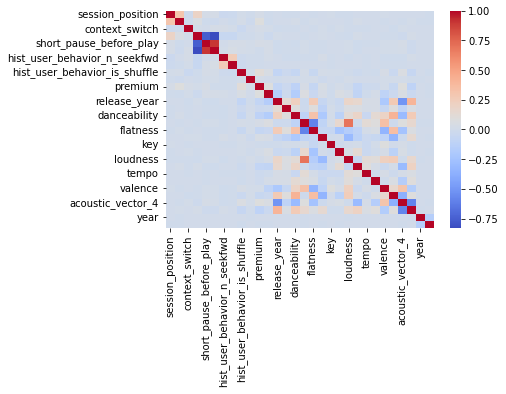

In [19]:
corr_matrix = data_X.corr()
import seaborn as sns

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap="coolwarm")

## Random Forest Classifier

Feature Selection

In [31]:
# Use subset of 10,000 rows
## Separate features from skip outcome
data_Y = subset[['response']]
data_X = subset.drop(columns=['response', 'session_id', 'track_id_clean', 'track_id'])

## Sample from data for hyperparameter tuning
X_train, X_test, y_train, y_test = train_test_split(data_X,data_Y, test_size=0.2)

In [36]:
### Pipeline
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',RandomForestClassifier())
])

# Optimize alpha parameter of Lasso regression
search = GridSearchCV(pipeline,
                        {'model__criterion':('gini', 'entropy', 'log_loss'),
                        'model__max_depth': np.arange(5,200,20),
                        'model__ccp_alpha': (0.01, 0.1, 1.0)
                        },
                        cv = 3, scoring="roc_auc_ovr",verbose=3, error_score='raise', n_jobs=-1
                        )

search.fit(X_train, np.array(y_train).ravel())
search.best_params_ # Parameters that give best AUC

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV 3/3] END model__ccp_alpha=0.01, model__criterion=gini, model__max_depth=5;, score=0.617 total time=   1.3s
[CV 1/3] END model__ccp_alpha=0.01, model__criterion=gini, model__max_depth=5;, score=0.638 total time=   1.3s
[CV 2/3] END model__ccp_alpha=0.01, model__criterion=gini, model__max_depth=5;, score=0.612 total time=   1.3s
[CV 2/3] END model__ccp_alpha=0.01, model__criterion=gini, model__max_depth=25;, score=0.624 total time=   3.6s
[CV 3/3] END model__ccp_alpha=0.01, model__criterion=gini, model__max_depth=25;, score=0.626 total time=   3.6s
[CV 1/3] END model__ccp_alpha=0.01, model__criterion=gini, model__max_depth=25;, score=0.622 total time=   3.7s
[CV 1/3] END model__ccp_alpha=0.01, model__criterion=gini, model__max_depth=45;, score=0.626 total time=   3.8s
[CV 2/3] END model__ccp_alpha=0.01, model__criterion=gini, model__max_depth=45;, score=0.623 total time=   3.9s
[CV 3/3] END model__ccp_alpha=0.01, model__cr

{'model__ccp_alpha': 0.01,
 'model__criterion': 'entropy',
 'model__max_depth': 85}

In [37]:
features = X_train.columns

In [43]:
rf_spotify = RandomForestClassifier(ccp_alpha=0.1, criterion='entropy', max_depth=85)
#rf_jeep = RandomForestClassifier(ccp_alpha=0.0, criterion='gini', max_depth=25)
rf_spotify.fit(X_train, y_train)
y_pred = rf_spotify.predict_proba(X_test)

# Identify best features
fi_spotify = list(zip(features,rf_spotify.feature_importances_))
fi_spotify.sort(key = lambda x : x[1])
print(fi_spotify)

[('session_position', 0.0), ('session_length', 0.0), ('context_switch', 0.0), ('no_pause_before_play', 0.0), ('short_pause_before_play', 0.0), ('long_pause_before_play', 0.0), ('hist_user_behavior_n_seekfwd', 0.0), ('hist_user_behavior_n_seekback', 0.0), ('hist_user_behavior_is_shuffle', 0.0), ('hour_of_day', 0.0), ('premium', 0.0), ('duration', 0.0), ('release_year', 0.0), ('us_popularity_estimate', 0.0), ('acousticness', 0.0), ('beat_strength', 0.0), ('bounciness', 0.0), ('danceability', 0.0), ('dyn_range_mean', 0.0), ('energy', 0.0), ('flatness', 0.0), ('instrumentalness', 0.0), ('key', 0.0), ('liveness', 0.0), ('loudness', 0.0), ('mechanism', 0.0), ('mode', 0.0), ('organism', 0.0), ('speechiness', 0.0), ('tempo', 0.0), ('time_signature', 0.0), ('valence', 0.0), ('acoustic_vector_0', 0.0), ('acoustic_vector_1', 0.0), ('acoustic_vector_2', 0.0), ('acoustic_vector_3', 0.0), ('acoustic_vector_4', 0.0), ('acoustic_vector_5', 0.0), ('acoustic_vector_6', 0.0), ('acoustic_vector_7', 0.0), 

In [42]:
# ROC Score using One vs. Rest
spotify_rf_auc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='weighted')
print("AUC value for validation set of RF Model/Jeep Make is: ", spotify_rf_auc)

AUC value for validation set of RF Model/Jeep Make is:  0.5
